In [102]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [98]:
features_to_keep = [
    'posteam',
    'defteam',
    'yardline_100',
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    'game_half',
    'quarter_end',
    'drive',
    'sp',
    'qtr',
    'down',
    'ydstogo',
    'ydsnet',
    'play_type',
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining',
    'posteam_score',
    'defteam_score',
    'score_differential',
    'ep',
    'epa'
    # Previous plays decreases the accuracy
    # 'previous_play1',
    # 'previous_play2',
    # 'previous_play3'
]


def set_previous_play1(row):
    if row['drive'] != row['previous_drive1']:
        return 'new_team'
    else:
        return row['previous_play1']


def set_previous_play2(row):
    if row['drive'] != row['previous_drive2']:
        return 'new_team'
    else:
        return row['previous_play2']


def set_previous_play3(row):
    if row['drive'] != row['previous_drive3']:
        return 'new_team'
    else:
        return row['previous_play3']


def load_nfl_data(file_path) -> [pd.DataFrame, pd.Series]:

    nfl_play_data: pd.DataFrame = pd.read_csv(file_path)

    # jank
    nfl_play_data[f'previous_play1'] = nfl_play_data['play_type'].shift(1)
    nfl_play_data[f'previous_drive1'] = nfl_play_data['drive'].shift(1)

    nfl_play_data[f'previous_play2'] = nfl_play_data['play_type'].shift(2)
    nfl_play_data[f'previous_drive2'] = nfl_play_data['drive'].shift(2)

    nfl_play_data[f'previous_play3'] = nfl_play_data['play_type'].shift(3)
    nfl_play_data[f'previous_drive3'] = nfl_play_data['drive'].shift(3)

    # add column for previous play(s)
    nfl_play_data['previous_play1'] = nfl_play_data.apply(set_previous_play1, axis=1)
    nfl_play_data['previous_play2'] = nfl_play_data.apply(set_previous_play2, axis=1)
    nfl_play_data['previous_play3'] = nfl_play_data.apply(set_previous_play3, axis=1)

    # keep only the columns listed
    nfl_play_data = nfl_play_data[features_to_keep]

    # remove any plays where play_type not in ('pass', 'run')
    nfl_play_data = nfl_play_data[nfl_play_data['play_type'].isin(['pass', 'run'])]

    nfl_play_data = nfl_play_data.dropna()

    # convert the number of seconds to hours
    nfl_play_data['quarter_seconds_remaining'] = nfl_play_data['quarter_seconds_remaining'] / 3600
    nfl_play_data['half_seconds_remaining'] = nfl_play_data['half_seconds_remaining'] / 3600
    nfl_play_data['game_seconds_remaining'] = nfl_play_data['game_seconds_remaining'] / 3600

    play_outcomes = pd.get_dummies(nfl_play_data.pop('play_type'))

    nfl_play_data = pd.get_dummies(nfl_play_data)

    return nfl_play_data, play_outcomes

In [99]:
X, y = load_nfl_data('nfl-play-by-play-2009-2018.csv')

# Only using one output column
y = y['run']

C:\Users\dalli\AppData\Local\Temp\ipykernel_23720\3125891946.py:54: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  nfl_play_data: pd.DataFrame = pd.read_csv(file_path)


In [100]:
# Best model
pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('model', BernoulliNB(alpha=10, binarize=0.1, fit_prior=True))
])

cv_scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy', n_jobs=-1)
average_cv_score = np.mean(cv_scores)
print(f"Average 10-fold CV Score for BernoulliNB: {average_cv_score}")

Average 10-fold CV Score for BernoulliNB: 0.6406620351688657


BernoulliNB Best CV Score: 0.6406620351688657
GaussianNB Best CV Score: 0.5971052055643435
MultinomialNB Best CV Score: 0.6114626457901308
ComplementNB Best CV Score: 0.5999528102059128


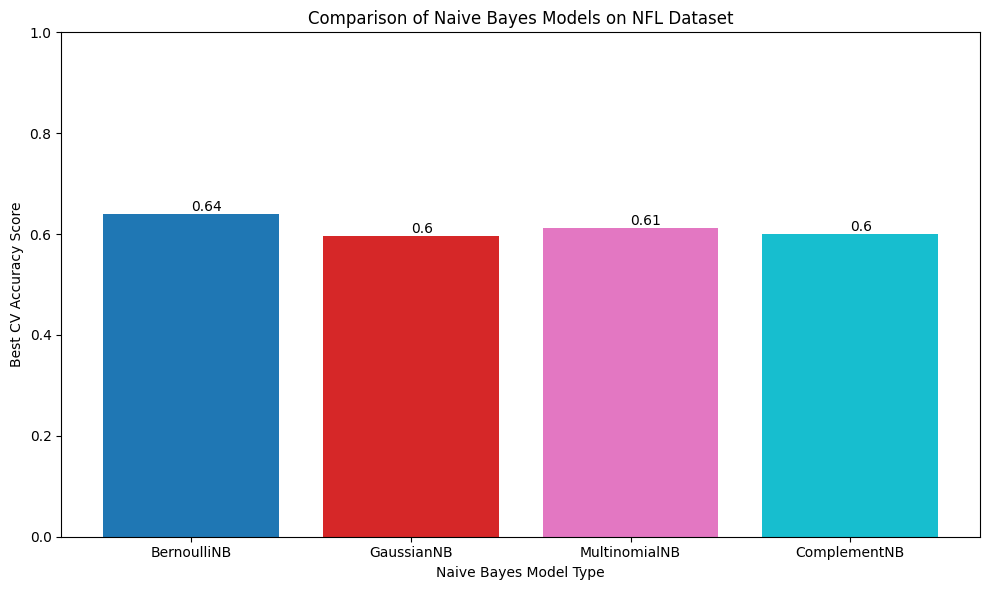

In [101]:
models_params = {
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10],
            'model__binarize': [0.1],
            'model__fit_prior': [True],
        },
        'preprocessing': MinMaxScaler(feature_range=(-1, 1))
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {},
        'preprocessing': None
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10],
            'model__fit_prior': [True],
        },
        'preprocessing': MinMaxScaler(feature_range=(0, 2))
    },
    'ComplementNB': {
        'model': ComplementNB(),
        'params': {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10],
            'model__fit_prior': [True],
            'model__norm': [True, False],
        },
        'preprocessing': MinMaxScaler(feature_range=(0, 2))
    }
}

results = {}

# Different preprocessing for GaussianNB
for model_name, mp in models_params.items():
    steps = []
    preprocessing = mp.get('preprocessing', None)
    if mp.get('preprocessing'):
        steps.append(('preprocessing', mp['preprocessing']))
    steps.append(('model', mp['model']))
    pipeline = Pipeline(steps=steps)
    
    grid_search = GridSearchCV(pipeline, mp['params'], cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    results[model_name] = grid_search.best_score_

# Printing accuracies
for model_name, score in results.items():
    print(f"{model_name} Best CV Score: {score}")

# Plotting the data
models = list(results.keys())
best_scores = list(results.values())
plt.figure(figsize=(10, 6))
bars = plt.bar(models, best_scores, color=plt.cm.tab10(np.linspace(0, 1, len(models))))
plt.xlabel('Naive Bayes Model Type')
plt.ylabel('Best CV Accuracy Score')
plt.title('Comparison of Naive Bayes Models on NFL Dataset')
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 2), va='bottom')
plt.tight_layout()
plt.show()